# Desafio Bolsista ICTi 2026
Candidata: Maria Eliza Antunes, Jan 2026

## Motivação do problema

No ambiente escolar, é comum observar perfis de aprendizagem heterogêneos: alguns alunos apresentam maior dificuldade com leitura, manutenção de atenção ou processamento de enunciados longos, enquanto outros se beneficiam de representações mais visuais ou de itens com menor complexidade textual. Durante uma avaliação ou mesmo em uma sessão de estudos, essas diferenças podem introduzir vieses, pois o instrumento avaliativo pode acabar medindo, em parte, a habilidade de ler e interpretar enunciados em vez do conhecimento específico do conteúdo. Assim, a motivação deste protótipo é construir um tutor que adapte formato e dificuldade de exercícios ao longo de uma sessão, buscando uma avaliação mais informativa, justa e viável para diferentes perfis de alunos.

## Objetivo do protótipo

Como produto, o protótipo pretende:

- Implementar e demonstrar uma política adaptativa que, a cada passo da sessão, selecione o próximo item em um espaço de ações reduzido, escolhendo entre um conjunto limitado de pares (formato, dificuldade) (4 formatos de questões × 5 níveis de dificuldade, totalizando 20 ações);

- Registrar e sumarizar, ao término da sessão (15–20 itens), um relatório do desempenho do aluno, incluindo:
  - Uma estimativa de domínio/habilidade do conteúdo (por exemplo, uma estimativa contínua atualizada item a item);
  - Uma caracterização do impacto do formato no desempenho e no engajamento (por exemplo, maior taxa de acerto e/ou menor queda de engajamento em itens de múltipla escolha versus itens com *scaffold*);

- Apresentar evidências quantitativas do desempenho do sistema em comparação com políticas de referência (*baselines*), tais como seleção aleatória e heurísticas do tipo “escadinha” (ajuste de dificuldade por acertos/erros), reportando métricas como retorno médio e taxa de abandono (e, quando aplicável, medidas de qualidade do diagnóstico).

## Descrição do environment

- O episódio representa uma sessão de estudos (tutor) com um aluno simulado;
- A cada passo, o agente escolhe (formato, dificuldade) e o ambiente simula acerto/erro e a evolução do engajamento;
- O estado observado pode ser descrito como:  
  `obs = [skill_est, skill_unc, engagement, last_correct, last_difficulty_norm, last_load]`,  
  onde `skill_est` é a estimativa do tutor para a habilidade e `last_load` representa a carga de leitura do último item.

### Apresentação

Este notebook roda um protótipo de tutor adaptativo de frações usando **RL**:
- 4 formatos de questões: `short_text`, `multiple_choice`, `visual` e `scaffold`
- 5 níveis de dificuldade: 1, 2, 3, 4 e 5
- Total: 20 ações (formato × dificuldade)

A ideia foi montar um banco de itens em duas camadas: (i) um conjunto base gerado offline por templates, garantindo cobertura por formato/dificuldade, reprodutibilidade e independência de quota; e (ii) itens adicionais gerados via LLM por API (seed), usados opcionalmente para ampliar a diversidade linguística e de exemplos. O ambiente e o RL utilizam apenas o banco final consolidado (JSONL), mantendo o uso de LLM fora do loop. Para reduzir variância do treinamento, o PPO foi treinado/avaliado com três seeds distintas (seed = S1, S2, S3), e os resultados reportados agregam essas execuções.




# 1 - Importando as bibliotecas necessárias

In [1]:
import os 
import json
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym #biblioteca RL
from gymnasium import spaces #espacos de acao e observacao

from tutor.envs.fraction_tutor_env import FractionTutorEnv, FORMATS, DIFFICULTIES #ambiente do tutor


# 2 - Gerando e carregando o banco de questões

In [2]:
import os
import subprocess, sys

os.makedirs("data", exist_ok=True) #para armazenar os dados

bank_templates = "data/items_bank_templates.jsonl" #banco gerado offline por templates
bank_seed = "data/items_seed.jsonl"      #banco gerado via API (gemini)
bank_final = "data/items_bank.jsonl"     #banco que o RL vai usar

#banco offline (caso ele ainda nao exista)
if not os.path.exists(bank_templates):
    subprocess.check_call([
        sys.executable, "scripts/generate_bank_templates.py",
        "--out", bank_templates,
        "--n_per_cell", "12", #12 itens por celula
        "--seed", "42" #reprodutibilidade
    ])

#construindo o banco final
with open(bank_final, "w", encoding="utf-8") as out:
    #templates
    with open(bank_templates, "r", encoding="utf-8") as f:
        for line in f:
            out.write(line)

    ##anexando itens gerados por LLM
    if os.path.exists(bank_seed):
        with open(bank_seed, "r", encoding="utf-8") as f:
            for line in f:
                out.write(line)

def count_lines(path):
    return sum(1 for _ in open(path, "r", encoding="utf-8")) if os.path.exists(path) else 0

print("Banco final de treino:", bank_final)
print(" - templates:", count_lines(bank_templates))
print(" - seed LLM :", count_lines(bank_seed))
print(" - total    :", count_lines(bank_final))

bank_path = bank_final  


Banco final de treino: data/items_bank.jsonl
 - templates: 240
 - seed LLM : 14
 - total    : 254


## 3 - Criando o ambiente

In [3]:
from tutor.envs.fraction_tutor_env import FractionTutorEnv #importando meu env

def make_env(seed=0, max_steps=20): #criar o ambiente sempre do mesmo jeito
    return FractionTutorEnv(bank_path=bank_path, max_steps=max_steps, seed=seed)

env = make_env(seed=0)
print("Espaço de ação:", env.action_space)  
print("Espaço de observação:", env.observation_space)

Espaço de ação: Discrete(20)
Espaço de observação: Box([-3.  0.  0.  0.  0.  0.], [3. 5. 1. 1. 1. 1.], (6,), float32)


# 4 - Definindo as policys baselines

In [ ]:

FORMATS = ["short_text", "multiple_choice", "visual", "scaffold"]
DIFFICULTIES = [1, 2, 3, 4, 5]

#convertendo (formato,dificuldade) em uma acao discreta
#a acao do agente representa qual tipo de questao e qual dificuldade ele vai apresentar
def cell_to_action(fmt: str, d: int) -> int:
    fmt_i = FORMATS.index(fmt)
    d_i = DIFFICULTIES.index(d)
    return fmt_i * len(DIFFICULTIES) + d_i

#rodando um ep completo pra gerar minha trajetoria
def run_episode(env, policy_fn, seed: int = 0):
    rng = np.random.default_rng(seed)
    obs, _ = env.reset(seed=seed)

    total_r = 0.0 #soma de recompensas
    done = False 
    trunc = False
    log = []

    while not (done or trunc):
        a = policy_fn(obs, rng, env)
        obs, r, done, trunc, info = env.step(int(a))
        total_r += float(r)
        log.append(info)

    return float(total_r), bool(done), bool(trunc), log


#random:
def policy_random(obs, rng, env) -> int:
    return int(rng.integers(env.action_space.n))

#staircase: ajusta dificuldade pelo acerto/erro, mas o formato é multipla escolha sempre
def policy_staircase(obs, rng, env) -> int:
    last_correct = float(obs[3])
    last_d_norm = float(obs[4])

    # d_prev em {1..5}
    d_prev = int(round(last_d_norm * (len(DIFFICULTIES) - 1))) + 1
    d_prev = max(1, min(5, d_prev))

    if last_correct >= 0.5:
        d = min(5, d_prev + 1)
    else:
        d = max(1, d_prev - 1)

    return cell_to_action("multiple_choice", d)

#engajamento: a dificuldade é ajustada por staircase mas o formato depende do engajamento do aluno naquele instante
def policy_engagement(obs, rng, env) -> int:
    engagement = float(obs[2])
    last_correct = float(obs[3])
    last_d_norm = float(obs[4])

    d_prev = int(round(last_d_norm * (len(DIFFICULTIES) - 1))) + 1
    d_prev = max(1, min(5, d_prev))

    if last_correct >= 0.5:
        d = min(5, d_prev + 1)
    else:
        d = max(1, d_prev - 1)

    if engagement < 0.45:
        fmt = rng.choice(["short_text", "multiple_choice"])
    else:
        fmt = rng.choice(["visual", "scaffold"])

    return cell_to_action(fmt, d)


#caso a sessao termine, investigando pq ela terminou
def infer_reason(last_info: dict, done: bool, trunc: bool, env) -> str:
    reason = last_info.get("reason", None)
    if reason is not None:
        return str(reason)

    #se truncou, foi limite de passos/time limit
    if trunc:
        return "time_limit"

    #alguns envs colocam isso no info
    if bool(last_info.get("TimeLimit.truncated", False)):
        return "time_limit"

    # fallback por engajamento (se ele existir no info)
    if done:
        eng = last_info.get("engagement", None)
        if eng is not None:
            #tenta pegar limiar do env; se não existir, usa um default conservador
            thr = getattr(env, "engagement_threshold", None)
            if thr is None:
                thr = getattr(env, "min_engagement", None)
            if thr is None:
                thr = 0.15
            if float(eng) <= float(thr):
                return "low_engagement"

        #fallback generico
        return "done_unknown"

    return "running"


##repetinfo eps com seeds diferentes para obter as estatisticas
def eval_policy(policy_fn, n_episodes: int = 200, seed: int = 8):
    returns = []
    abandons = []
    steps_list = []
    completes = []
    reasons = {}

    for i in range(n_episodes):
        env = make_env(seed=seed + i)  # novo env por episódio (aluno e amostragem reprodutíveis)
        total_r, done, trunc, log = run_episode(env, policy_fn, seed=seed + i)
        returns.append(total_r)
        steps_list.append(len(log))

        last_info = log[-1] if log else {}
        reason = infer_reason(last_info, done=bool(done), trunc=bool(trunc), env=env)
        reasons[reason] = reasons.get(reason, 0) + 1

        # done=True e trunc=False geralmente indica abandono por engajamento baixo
        abandoned = (reason == "low_engagement") or (bool(done) and (not bool(trunc)) and (reason != "empty_cell") and (reason != "time_limit"))
        abandons.append(1.0 if abandoned else 0.0)

        # sessão completa = trunc por limite (max_steps) OU reason time_limit
        completed = bool(trunc) or (reason == "time_limit")
        completes.append(1.0 if completed else 0.0)

    returns = np.asarray(returns, dtype=float)
    steps_arr = np.asarray(steps_list, dtype=float)
    abandons = np.asarray(abandons, dtype=float)
    completes = np.asarray(completes, dtype=float)

    return {
        "mean_return": float(returns.mean()),
        "std_return": float(returns.std(ddof=1)) if len(returns) > 1 else 0.0,
        "abandon_rate": float(abandons.mean()),
        "mean_steps": float(steps_arr.mean()),
        "std_steps": float(steps_arr.std(ddof=1)) if len(steps_arr) > 1 else 0.0,
        "completion_rate": float(completes.mean()),
        "reasons": reasons,
        "returns": returns,
        "steps": steps_arr,
        "abandons": abandons,
    }

# roda baselines
res_rand = eval_policy(policy_random)
res_stair = eval_policy(policy_staircase)
res_eng = eval_policy(policy_engagement)

print("Random:    retorno médio =", res_rand["mean_return"], "±", res_rand["std_return"], "| abandono =", res_rand["abandon_rate"], "| passos =", res_rand["mean_steps"], "| complete =", res_rand["completion_rate"])
print("Staircase: retorno médio =", res_stair["mean_return"], "±", res_stair["std_return"], "| abandono =", res_stair["abandon_rate"], "| passos =", res_stair["mean_steps"], "| complete =", res_stair["completion_rate"])
print("Eng-aware: retorno médio =", res_eng["mean_return"], "±", res_eng["std_return"], "| abandono =", res_eng["abandon_rate"], "| passos =", res_eng["mean_steps"], "| complete =", res_eng["completion_rate"])

print("\nReasons (Random):   ", res_rand["reasons"])
print("Reasons (Staircase):", res_stair["reasons"])
print("Reasons (Eng-aware):", res_eng["reasons"])


Random:    retorno médio = -3.245189331970896 ± 3.5883699587064988 | abandono = 1.0 | passos = 9.165 | complete = 0.0
Staircase: retorno médio = -1.0820309442176579 ± 2.4410491959274485 | abandono = 0.98 | passos = 13.465 | complete = 0.02
Eng-aware: retorno médio = -1.8073522594230504 ± 2.368155941545663 | abandono = 0.995 | passos = 11.66 | complete = 0.005

Reasons (Random):    {'low_engagement': 200}
Reasons (Staircase): {'low_engagement': 196, 'time_limit': 4}
Reasons (Eng-aware): {'low_engagement': 199, 'time_limit': 1}


# 5 - Treinando o PPO

In [5]:
from pathlib import Path
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from tutor.envs.fraction_tutor_env import FractionTutorEnv


seed = 0
timesteps = 50_000 
model_path = "models/ppo_20actions.zip"
vn_path = "models/vecnormalize.pkl"

print("Usando banco:", bank_path)

#criando o ambiente vetorizado e a normalizacao
def _make_env():
    return FractionTutorEnv(bank_path=bank_path, max_steps=20, seed=seed)

vec_env = DummyVecEnv([_make_env])
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=5.0)

#definindo o PPO
model = PPO(
    "MlpPolicy",
    vec_env,
    seed=seed,
    verbose=1,
    n_steps=512,
    batch_size=128,
    gamma=0.99,
    learning_rate=3e-4,
)

model.learn(total_timesteps=timesteps) #treino

#salvando
Path("models").mkdir(exist_ok=True)
model.save(model_path)
vec_env.save(vn_path)

print("Treino concluido!")
print("Saved model ->", model_path)
print("Saved VecNormalize ->", vn_path)

#testando
obs = vec_env.reset()
a, _ = model.predict(obs, deterministic=True)
a_int = int(a[0]) if hasattr(a, "__len__") else int(a)

print("Ação escolhida no estado inicial:", a_int)


Usando banco: data/items_bank.jsonl
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1586 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 512  |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 1383        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.003945055 |
|    clip_fraction        | 0.00234     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.99       |
|    explained_variance   | -0.591      |
|    learning_rate        | 0.0003      |
|    loss                 | 0.484       |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0152     |
|    value_loss           | 1.94        |
-----------------------

# 6 - Comparando PPO e as baselines

PPO: retorno medio = 13.107380916029214 ± 6.368457780707668 | abandono = 0.035 | passos = 19.8


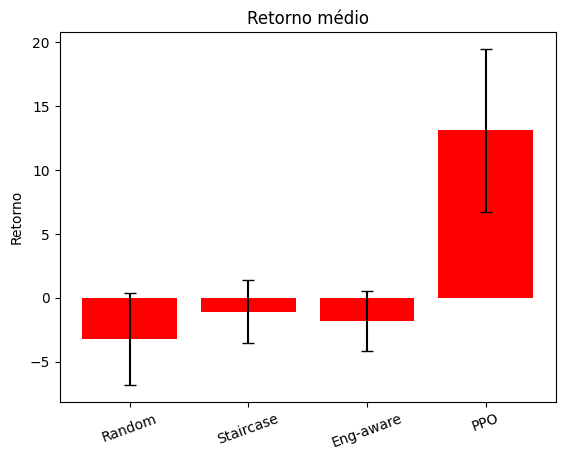

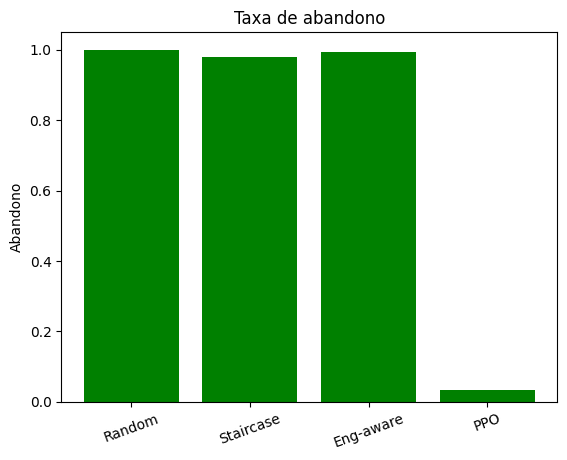

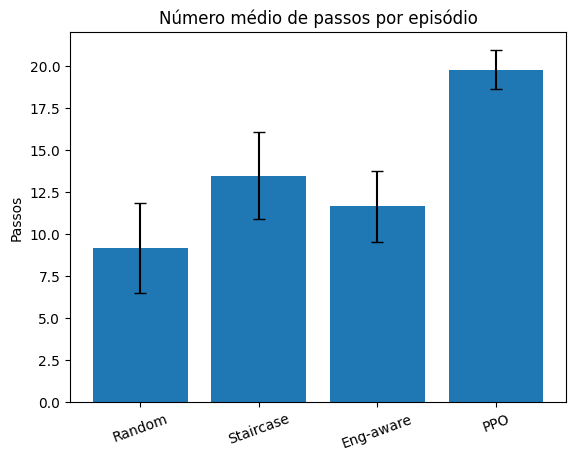

In [7]:
from pathlib import Path
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
model_path = Path("models/ppo_20actions.zip") #modelo treinado
vecnorm_path = Path("models/vecnormalize.pkl") #estatisticas de nroamlizacao do treino

res_ppo = None

if model_path.exists() and vecnorm_path.exists():
    def _thunk_eval():
        return FractionTutorEnv(bank_path=bank_path, max_steps=20, seed=123) #criando um env de avaliacao

    venv = DummyVecEnv([_thunk_eval])
    venv = VecNormalize.load(str(vecnorm_path), venv)
    venv.training = False #nao atualizo as medias e desvios durante a avaliacao
    venv.norm_reward = False #nao normalizo os rewards

    ppo = PPO.load(str(model_path), env=venv)

#rodando o ppo em varios episodios
    def eval_ppo(model, venv, n_episodes: int = 200, seed: int = 999):
        returns = []
        abandons = []
        steps_list = []

        for i in range(n_episodes):
            try:
                obs = venv.reset(seed=seed + i)
            except TypeError:
                obs = venv.reset()
            total_r = 0.0
            steps = 0

#agente-ambiente
            while True:
                action, _ = model.predict(obs, deterministic=True)
                obs, reward, done, infos = venv.step(action)
                total_r += float(reward[0])
                steps += 1

                if bool(done[0]):
                    info0 = infos[0] if infos else {}
                    trunc = bool(info0.get("TimeLimit.truncated", False))
                    reason = info0.get("reason", None)
                    abandoned = (not trunc) and (reason != "empty_cell")
                    returns.append(total_r)
                    abandons.append(1.0 if abandoned else 0.0)
                    steps_list.append(steps)
                    break

        returns = np.asarray(returns, dtype=float)
        steps_arr = np.asarray(steps_list, dtype=float)
        abandons = np.asarray(abandons, dtype=float)

        return {
            "mean_return": float(returns.mean()),
            "std_return": float(returns.std(ddof=1)) if len(returns) > 1 else 0.0,
            "abandon_rate": float(abandons.mean()),
            "mean_steps": float(steps_arr.mean()),
            "std_steps": float(steps_arr.std(ddof=1)) if len(steps_arr) > 1 else 0.0,
            "returns": returns,
            "steps": steps_arr,
            "abandons": abandons,
        }

    res_ppo = eval_ppo(ppo, venv, n_episodes=200, seed=999)
    print("PPO: retorno medio =", res_ppo["mean_return"], "±", res_ppo["std_return"], "| abandono =", res_ppo["abandon_rate"], "| passos =", res_ppo["mean_steps"])
else:
    print("Modelo PPO/VecNormalize não encontrado. Pulei a avaliacaoo PPO.")

##montando os graficos finais
labels = ["Random", "Staircase", "Eng-aware"] + (["PPO"] if res_ppo is not None else [])
mean_returns = [res_rand["mean_return"], res_stair["mean_return"], res_eng["mean_return"]] + ([res_ppo["mean_return"]] if res_ppo is not None else [])
std_returns  = [res_rand["std_return"],  res_stair["std_return"],  res_eng["std_return"]]  + ([res_ppo["std_return"]]  if res_ppo is not None else [])
abandon_rates = [res_rand["abandon_rate"], res_stair["abandon_rate"], res_eng["abandon_rate"]] + ([res_ppo["abandon_rate"]] if res_ppo is not None else [])
mean_steps = [res_rand["mean_steps"], res_stair["mean_steps"], res_eng["mean_steps"]] + ([res_ppo["mean_steps"]] if res_ppo is not None else [])
std_steps  = [res_rand["std_steps"],  res_stair["std_steps"],  res_eng["std_steps"]]  + ([res_ppo["std_steps"]]  if res_ppo is not None else [])

# Retorno médio com barra de erro (std)
plt.figure()
plt.bar(labels, mean_returns, yerr=std_returns, capsize=4, color='red')
plt.title("Retorno médio")
plt.xticks(rotation=20)
plt.ylabel("Retorno")
plt.show()

# Taxa de abandono
plt.figure()
plt.bar(labels, abandon_rates, color='green')
plt.title("Taxa de abandono")
plt.xticks(rotation=20)
plt.ylabel("Abandono")
plt.show()

# Passos médios (quantas questões até terminar)
plt.figure()
plt.bar(labels, mean_steps, yerr=std_steps, capsize=4)
plt.title("Número médio de passos por episódio")
plt.xticks(rotation=20)
plt.ylabel("Passos")
plt.show()


# 7 - Gerando um relatório para o aluno

In [8]:
import numpy as np
from report import template_report

if res_ppo is None:
    print("PPO nao foi carregado acima (modelo/vecnormalize nao encontrados). Pulei relatorio.")
else:
    # Policy ppo para rodar
    def policy_ppo_report(obs, rng, env=None):
        obs_arr = np.asarray(obs, dtype=np.float32).reshape(1, -1)  # (1, obs_dim)
        obs_norm = venv.normalize_obs(obs_arr)                      # normaliza igual ao treino
        action, _ = ppo.predict(obs_norm, deterministic=True)
        return int(np.asarray(action).item())

   
    total_r, done, trunc, log = run_episode(make_env(seed=3), policy_ppo_report, seed=999)
    print("Retorno:", total_r, "| done:", done, "| trunc:", trunc)
    print()
    print(template_report(log))


Retorno: 8.85579975661206 | done: False | trunc: True

Relatório da sessão (protótipo Desafio bolsista ICTi 2026)

Total de itens: 20

Distribuição por formato:
- short_text: 16 itens | acerto ~ 62%
- visual: 4 itens | acerto ~ 50%

Próximos passos sugeridos:
- Revisar habilidades com mais erros e repetir com dificuldade 1-2.
- Aumentar dificuldade gradualmente quando o acerto ficar acima de ~70%.


# 8 - PPO com 3 seeds


=== Treinando PPO seed=0 ===
seed 0 | return = 12.86077084288001 | abandono = 0.015 | steps = 19.985

=== Treinando PPO seed=1 ===
seed 1 | return = 13.42679963439703 | abandono = 0.0 | steps = 20.0

=== Treinando PPO seed=2 ===
seed 2 | return = 13.4067716242373 | abandono = 0.015 | steps = 19.985

=== PPO (3 seeds) — agregado ===
Return:  13.231 ± 0.321
Abandono:0.010 ± 0.009
Steps:   19.990 ± 0.009


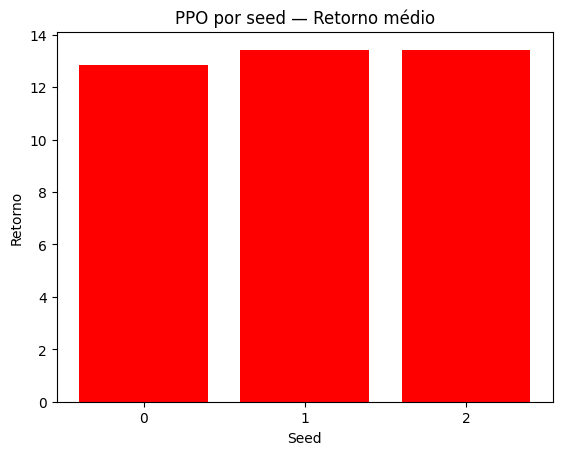

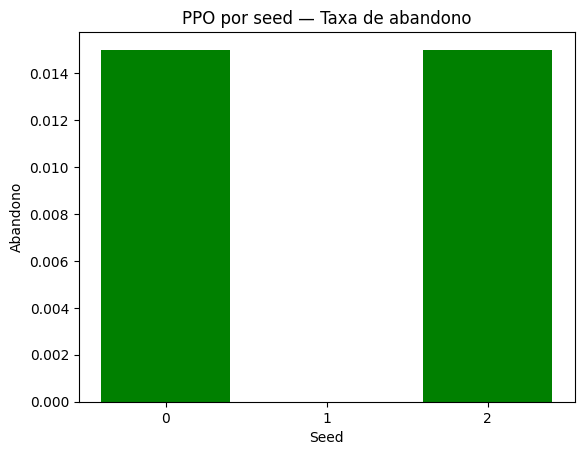

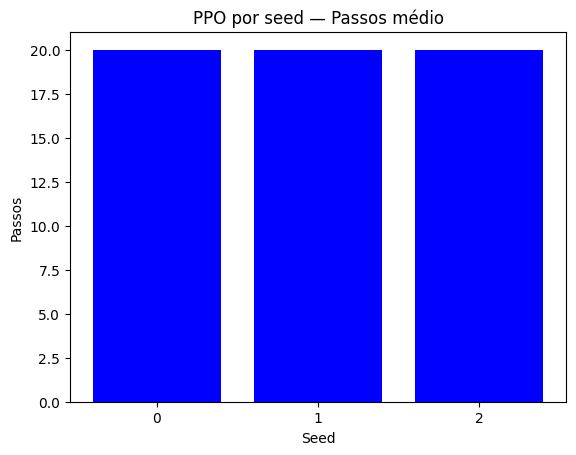

In [17]:
from pathlib import Path
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

Path("models").mkdir(exist_ok=True)

#treinando o PPO para uma seed especifica
def train_one_seed(seed: int, timesteps: int = 50_000):
    #env vetorizado
    def _make_env():
        return FractionTutorEnv(bank_path=bank_path, max_steps=20, seed=seed)

    venv = DummyVecEnv([_make_env])
    venv = VecNormalize(venv, norm_obs=True, norm_reward=True, clip_obs=5.0)

    model = PPO(
        "MlpPolicy",
        venv,
        seed=seed,
        verbose=0,
        n_steps=512,
        batch_size=128,
        gamma=0.99,
        learning_rate=3e-4,
    )

    model.learn(total_timesteps=timesteps)
    return model, venv

#3 seeds
seeds = [0, 1, 2]
timesteps = 50_000
n_eval_eps = 200 #avalio cada modelo em 200 ep

all_runs = [] #guardando os resultados

for s in seeds:
    print(f"\n=== Treinando PPO seed={s} ===")
    model, venv = train_one_seed(seed=s, timesteps=timesteps)

    #salvar por seed
    model_path = Path(f"models/ppo_seed{s}.zip")
    vn_path = Path(f"models/vecnormalize_seed{s}.pkl")
    model.save(str(model_path))
    venv.save(str(vn_path))

    #avaliacao
    venv.training = False
    venv.norm_reward = False

    res = eval_ppo(model, venv, n_episodes=n_eval_eps, seed=999)
    res["seed"] = s
    all_runs.append(res)

    print("seed", s, "| return =", res["mean_return"], "| abandono =", res["abandon_rate"], "| steps =", res["mean_steps"])

#media ± desvio entre seeds
mean_return = np.mean([r["mean_return"] for r in all_runs])
std_return  = np.std([r["mean_return"] for r in all_runs], ddof=1)

mean_abandon = np.mean([r["abandon_rate"] for r in all_runs])
std_abandon  = np.std([r["abandon_rate"] for r in all_runs], ddof=1)

mean_steps = np.mean([r["mean_steps"] for r in all_runs])
std_steps  = np.std([r["mean_steps"] for r in all_runs], ddof=1)

print("\n=== PPO (3 seeds) — agregado ===")
print(f"Return:  {mean_return:.3f} ± {std_return:.3f}")
print(f"Abandono:{mean_abandon:.3f} ± {std_abandon:.3f}")
print(f"Steps:   {mean_steps:.3f} ± {std_steps:.3f}")

##plotando
seeds = [r["seed"] for r in all_runs]
returns = [r["mean_return"] for r in all_runs]
abandons = [r["abandon_rate"] for r in all_runs]
steps = [r["mean_steps"] for r in all_runs]

def bar_metric(vals, title, ylabel, color=None):
    plt.figure()
    plt.bar([str(s) for s in seeds], vals, color=color)
    plt.title(title)
    plt.xlabel("Seed")
    plt.ylabel(ylabel)
    plt.show()

bar_metric(returns,  "PPO por seed — Retorno médio", "Retorno", color="red")
bar_metric(abandons, "PPO por seed — Taxa de abandono", "Abandono", color="green")
bar_metric(steps,    "PPO por seed — Passos médio", "Passos", color="blue")



